In [3]:
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate
import torch
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
%matplotlib inline

In [2]:
def load_model(module=MetrixXYHistSurrogate, checkpoint_path: str="outputs/xy_hist/muqyzwbp/checkpoints/epoch=8739-step=106732880.ckpt"):
    model = module.load_from_checkpoint(checkpoint_path)
    model.to(torch.device('cpu'))
    model.compile()
    model.eval()
    return model

model = load_model()

/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'last_activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['last_activation'])`.


Sequential(
  (0): Linear(in_features=34, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=77, bias=True)
  (3): ReLU()
  (4): Linear(in_features=77, out_features=87, bias=True)
  (5): ReLU()
  (6): Linear(in_features=87, out_features=100, bias=True)
  (7): Sigmoid()
)


In [3]:
with torch.no_grad():
    out = model(torch.ones((1, 34))*0.5).reshape(2, -1)
    print(out.shape)

torch.Size([2, 50])


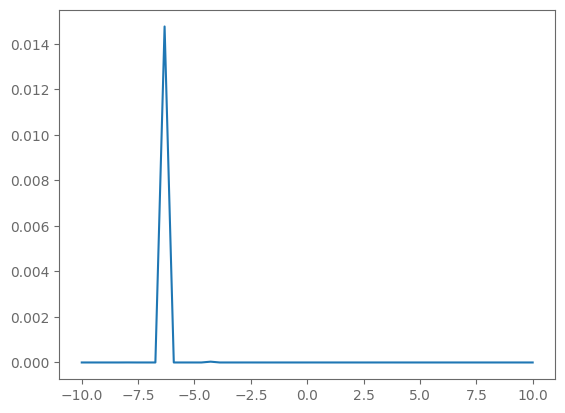

In [4]:

plt.plot(torch.linspace(-10, 10, 50), out[0]*22594.)
#plt.show()

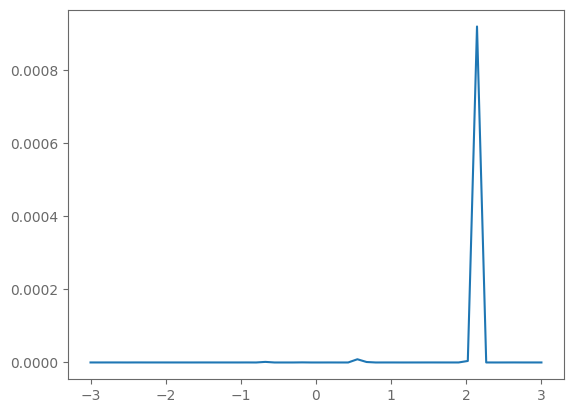

In [5]:
plt.plot(torch.linspace(-3, 3, 50), out[1]*22594.)

In [4]:
from ray_nn.data.transform import Select
from ray_nn.nn.xy_hist_data_models import StandardizeXYHist
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset
import glob
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/50+50_data_raw_*.h5')) # ['datasets/metrix_simulation/ray_emergency_surrogate/49+50_data_raw_0.h5']

load_len = 1000

dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/histogram', '1e5/n_rays'], transform=Select(keys=['1e5/params', '1e5/histogram', '1e5/n_rays'], search_space=params(), non_dict_transform={'1e5/histogram': StandardizeXYHist()}))

memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)#, min_n_rays=500)

  6%|▌         | 55/1000 [00:04<01:01, 15.41it/s]

KeyboardInterrupt: 

12 torch.Size([34]) torch.Size([2, 50, 1])
tensor(5.1400)
tensor([0.9346, 0.0364, 0.0351, 0.8847, 0.5996, 0.0208, 0.7500, 0.0226, 0.6771,
        0.4640, 0.1809, 0.0213, 0.3900, 0.4234, 0.1920, 0.7920, 0.5679, 0.2175,
        0.1767, 0.3548, 0.1172, 0.7044, 0.6402, 0.6648, 0.5946, 0.9630, 0.4034,
        0.0215, 0.3933, 0.1175, 0.2736, 0.8222, 0.0265, 0.2303])


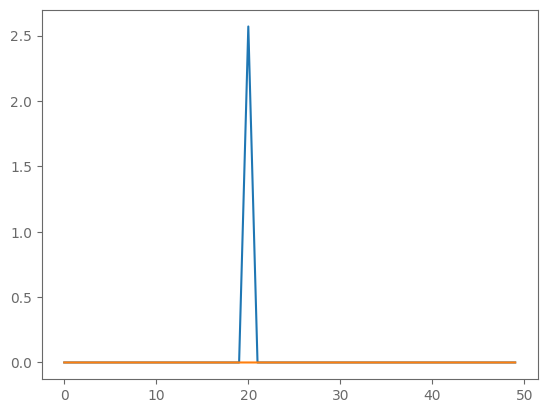

In [30]:
for i,z in enumerate(memory_dataset):
    x = z[0]
    y = z[1]
    with torch.no_grad():
        if y.sum() > 5:
            print(i, x.shape, y.shape)
            print(y.sum())
            out = model(x).reshape(2, -1)
            plt.plot(y[0].flatten())
            plt.plot(out[0].detach().cpu())
            print(x)
            break

In [7]:
len(memory_dataset)

1000

In [8]:
#for tu in memory_dataset:
#    x = tu[0]
#    y = tu[1]
    #print(x.shape)
    #print(y.shape)

In [10]:
with torch.no_grad():
    
    print(out.shape)


torch.Size([2, 50])


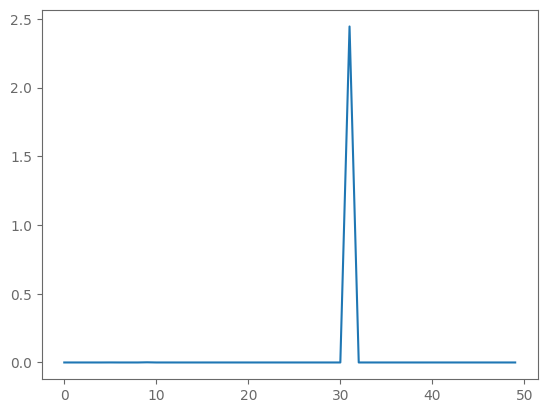

In [23]:
plt.plot(out[0]*22594*70)

In [6]:
from ray_nn.data.lightning_data_module import DefaultDataModule
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate
import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor
import glob
from ray_nn.data.transform import Select
from ray_nn.nn.xy_hist_data_models import StandardizeXYHist
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset
import glob
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from lightning.pytorch.loggers import WandbLogger

load_len: int | None = None
dataset_normalize_outputs = True
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/50+50_data_raw_*.h5')) # ['datasets/metrix_simulation/ray_emergency_surrogate/49+50_data_raw_0.h5']
dataset = RayDataset(h5_files=h5_files,
                    sub_groups=['1e5/params',
                                '1e5/histogram', '1e5/n_rays'], transform=Select(keys=['1e5/params', '1e5/histogram', '1e5/n_rays'], search_space=params(), non_dict_transform={'1e5/histogram': StandardizeXYHist()}))

memory_dataset = BalancedMemoryDataset(dataset=dataset, load_len=load_len, min_n_rays=500)
datamodule = DefaultDataModule(dataset=memory_dataset, num_workers=4)
datamodule.prepare_data()
model = MetrixXYHistSurrogate(dataset_length=load_len, dataset_normalize_outputs=dataset_normalize_outputs)
wandb_logger = WandbLogger(name="ref_bal_500_sch_.999_test", project="xy_hist", save_dir='outputs')
#wandb_logger = None
datamodule.setup(stage="test")

lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = L.Trainer(max_epochs=10000, logger=wandb_logger, log_every_n_steps=100, check_val_every_n_epoch=1, callbacks=[lr_monitor])
trainer.init_module()

trainer.test(datamodule=datamodule, ckpt_path='outputs/xy_hist/pd388nv8/checkpoints/epoch=755-step=147239316.ckpt', model=model)

100%|██████████| 100/100 [00:14<00:00,  6.86it/s]
/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'last_activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['last_activation'])`.


Sequential(
  (0): Linear(in_features=34, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=77, bias=True)
  (3): ReLU()
  (4): Linear(in_features=77, out_features=87, bias=True)
  (5): ReLU()
  (6): Linear(in_features=87, out_features=100, bias=True)
  (7): Sigmoid()
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
Restoring states from the checkpoint path at outputs/xy_hist/pd388nv8/checkpoints/epoch=755-step=147239316.ckpt
Loaded model weights from the checkpoint at outputs/xy_hist/pd388nv8/checkpoints/epoch=755-step=147239316.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.13191154599189758
    val_nonempty_loss       0.13207131624221802
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_nonempty_loss': 0.13207131624221802, 'val_loss': 0.13191154599189758}]

In [5]:
trainer.test(datamodule=datamodule, ckpt_path='outputs/xy_hist/pd388nv8/checkpoints/epoch=755-step=147239316.ckpt', model=model)

Restoring states from the checkpoint path at outputs/xy_hist/pd388nv8/checkpoints/epoch=755-step=147239316.ckpt


RuntimeError: Error(s) in loading state_dict for MetrixXYHistSurrogate:
	While copying the parameter named "validation_y_plot_data", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([0]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "validation_y_hat_plot_data", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([0]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "validation_y_empty_plot_data", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([0]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "validation_y_hat_empty_plot_data", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([0]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "train_y_empty_plot_data", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([0]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "train_y_plot_data", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([0]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "train_y_hat_empty_plot_data", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([0]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "train_y_hat_plot_data", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([0]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).